# 目标

- 把OpenCV中处理好的图像在Qt应用中显示。
    1. 使用OpenCV处理机器视觉相关的逻辑；
    2. 使用Qt作为终端应用；

# 使用的API

- 这里只列出图像有关的核心API，有关Qt的GUI API参考Qt相关文档。

1. 读取图像
    - `Mat cv::imread(const String &filename,  int flags=IMREAD_COLOR )`
        - 返回一个Mat数据结构；
        - 支持的图像累类型如下：
            1. `Windows bitmaps - *.bmp, *.dib (always supported)`
            2. `JPEG files - *.jpeg, *.jpg, *.jpe (see the Note section)`
            3. `JPEG 2000 files - *.jp2 (see the Note section)`
            4. `Portable Network Graphics - *.png (see the Note section)`
            5. `WebP - *.webp (see the Note section)`
            6. `Portable image format - *.pbm, *.pgm, *.ppm *.pxm, *.pnm (always supported)`
            7. `PFM files - *.pfm (see the Note section)`
            8. `Sun rasters - *.sr, *.ras (always supported)`
            9. `TIFF files - *.tiff, *.tif (see the Note section)`
            10. `OpenEXR Image files - *.exr (see the Note section)`
            11. `Radiance HDR - *.hdr, *.pic (always supported)`
            12. `Raster and Vector geospatial data supported by GDAL (see the Note section)`
2. 图像的颜色空间转换；
    - `void cv::cvtColor (InputArray src, OutputArray dst, int code, int dstCn=0)`
        - 需要指定转换方式：`int code`，OpenCV读取图像是按照GBRA存放到Mat结构（如果是24位色，则是BGR），一般应用API采用的都是RGBA。
        - 所以我们选择转换格式为：`cv::COLOR_BGRA2RGBA`
3. 获取图像相关信息：
    - 高度，宽度，深度
        - Mat的属性成员数据：`int 	cols`
        - Mat的属性成员数据：`int 	rows`
        - Mat的属性成员函数：`int 	depth()`，返回的数据格式由如下宏定义：
            - 1. CV_8U - 8-bit unsigned integers ( 0..255 )：一般读取的格式都是0-255的无符号字节整数；这个宏就是0
            - 2. CV_8S - 8-bit signed integers ( -128..127 )
            - 3. CV_16U - 16-bit unsigned integers ( 0..65535 )
            - 4. CV_16S - 16-bit signed integers ( -32768..32767 )
            - 5. CV_32S - 32-bit signed integers ( -2147483648..2147483647 )
            - 6. CV_32F - 32-bit floating-point numbers ( -FLT_MAX..FLT_MAX, INF, NAN )
            - 7. CV_64F - 64-bit floating-point numbers ( -DBL_MAX..DBL_MAX, INF, NAN )
    - 获取图像数据数组
        - Mat的属性成员数据：`uchar * 	data`
            - 返回的是无符号字节指针。（还有一个成员函数有ptr是一样的作用。ptr可以指定数据的开始与结束位置，这样可以获取局部部分数据）；
4. 使用图像像素数组构造QImage；
    - `QImage(const uchar *data, int width, int height, QImage::Format format, QImageCleanupFunction cleanupFunction = nullptr, void *cleanupInfo = nullptr)`
        - 需要指定图像的高宽，与格式，Qt的图像一般是：`QImage::Format_RGBA8888`(32位)与`QImage::Format_RGB888`（24位）
5. 使用QImage构造QPixmap；
    - `QPixmap QPixmap::fromImage(QImage &&image, Qt::ImageConversionFlags flags = Qt::AutoColor)`
        - 使用工具函数转换，而不是构造器构造。
6. 使图像大小适合标签框大小；
    - `void	setScaledContents(bool)`
        - 当然我们希望设置为true。
7. 把图像关联到标签框；
    - `void	setPixmap(const QPixmap &)`
        - 参数使用的是QPixmap引用，直接传递对象即可，不需要对象指针。

# 程序实现代码

- 具体过程可以参考注释

```C++
#include <QApplication>
#include <QDialog>
#include <QLabel>
// #include <QImage>    // 不需要引入
// #include <QPixmap>
////////////////////////////////
#include <opencv2/opencv.hpp>
///////////////////////////////
#include <iostream>

int main(int argc, char* argv[]) {
    // 初始化QT应用
    QApplication app(argc, argv);
    // 创建一个对话框
    QDialog  dlg;
    // 设置对话框大小
    dlg.setWindowTitle("机器视觉之OpenCV图像处理");
    dlg.setGeometry(100,100,400,300);

    // 显示图片的标签框
    QLabel lbl_image("显示图片", &dlg); // 以dlg作为父窗体
    // 图片框大小位置
    lbl_image.setGeometry(0,0, 400,300);

    // 定义图像缓冲
    cv::Mat src_image;
    cv::Mat image;
    // 打开图像
    src_image = cv::imread("bird.png", cv::IMREAD_COLOR);
    // 转换图像颜色空间
    cv::cvtColor(src_image, image, cv::COLOR_BGRA2RGBA);  // opencv读取数据的格式是BGRA，需要转换为QT能处理的格式
    // 把图像转换: cv::Mat -> QImage -> QPixmap -> 设置到QLabel
    const uchar *u_image = image.data;
    QImage img_buffer(u_image, image.cols, image.rows, QImage::Format_RGBA8888);
    QPixmap img_map = QPixmap::fromImage(img_buffer);
    lbl_image.setPixmap(img_map);
    lbl_image.setScaledContents(true);
    // std::cout<< image.dims<<std::endl;
    // std::cout<< image.depth()<<std::endl;
    dlg.show();
    return app.exec();
}

```

# 编译与链接脚本

- 环境Mac OS的clang编译器与连接器
- 脚本使用Makefile（这里暂时不使用CMake的编译方式）

- **Makefile文件如下：**

```bash

INCLUDES 	= -I/Users/yangqiang/Qt512/5.12.1/Src/qtbase/include \
                      -I/Users/yangqiang/Qt512/5.12.1/Src/qtbase/include/QtCore \
                      -I/Users/yangqiang/Qt512/5.12.1/Src/qtbase/include/GtGui \
                      -I/Users/yangqiang/Qt512/5.12.1/Src/qtbase/include/QtWidgets \
                      -I/usr/local/include/opencv4/

LIBS		= -lopencv_core \
			     -lopencv_highgui \
			     -lopencv_imgcodecs \
			     -lopencv_imgproc

SOURCES  	= main.cpp

FRAMEWORKS 	= -F/Users/yangqiang/Qt512/5.12.1/clang_64/lib \
			              -framework QtCore  \
		                  -framework QtGui  \
		                  -framework QtWidgets
                          
LD_ARGS		= -Wl,-rpath,/Users/yangqiang/Qt512/5.12.1/clang_64/lib

main: main.cpp
	g++ -omain $(SOURCES) -std=c++11 $(INCLUDES) $(LIBS)  $(FRAMEWORKS) $(LD_ARGS)

clean:
	rm -f main

```

# 结果

1. 编译与链接

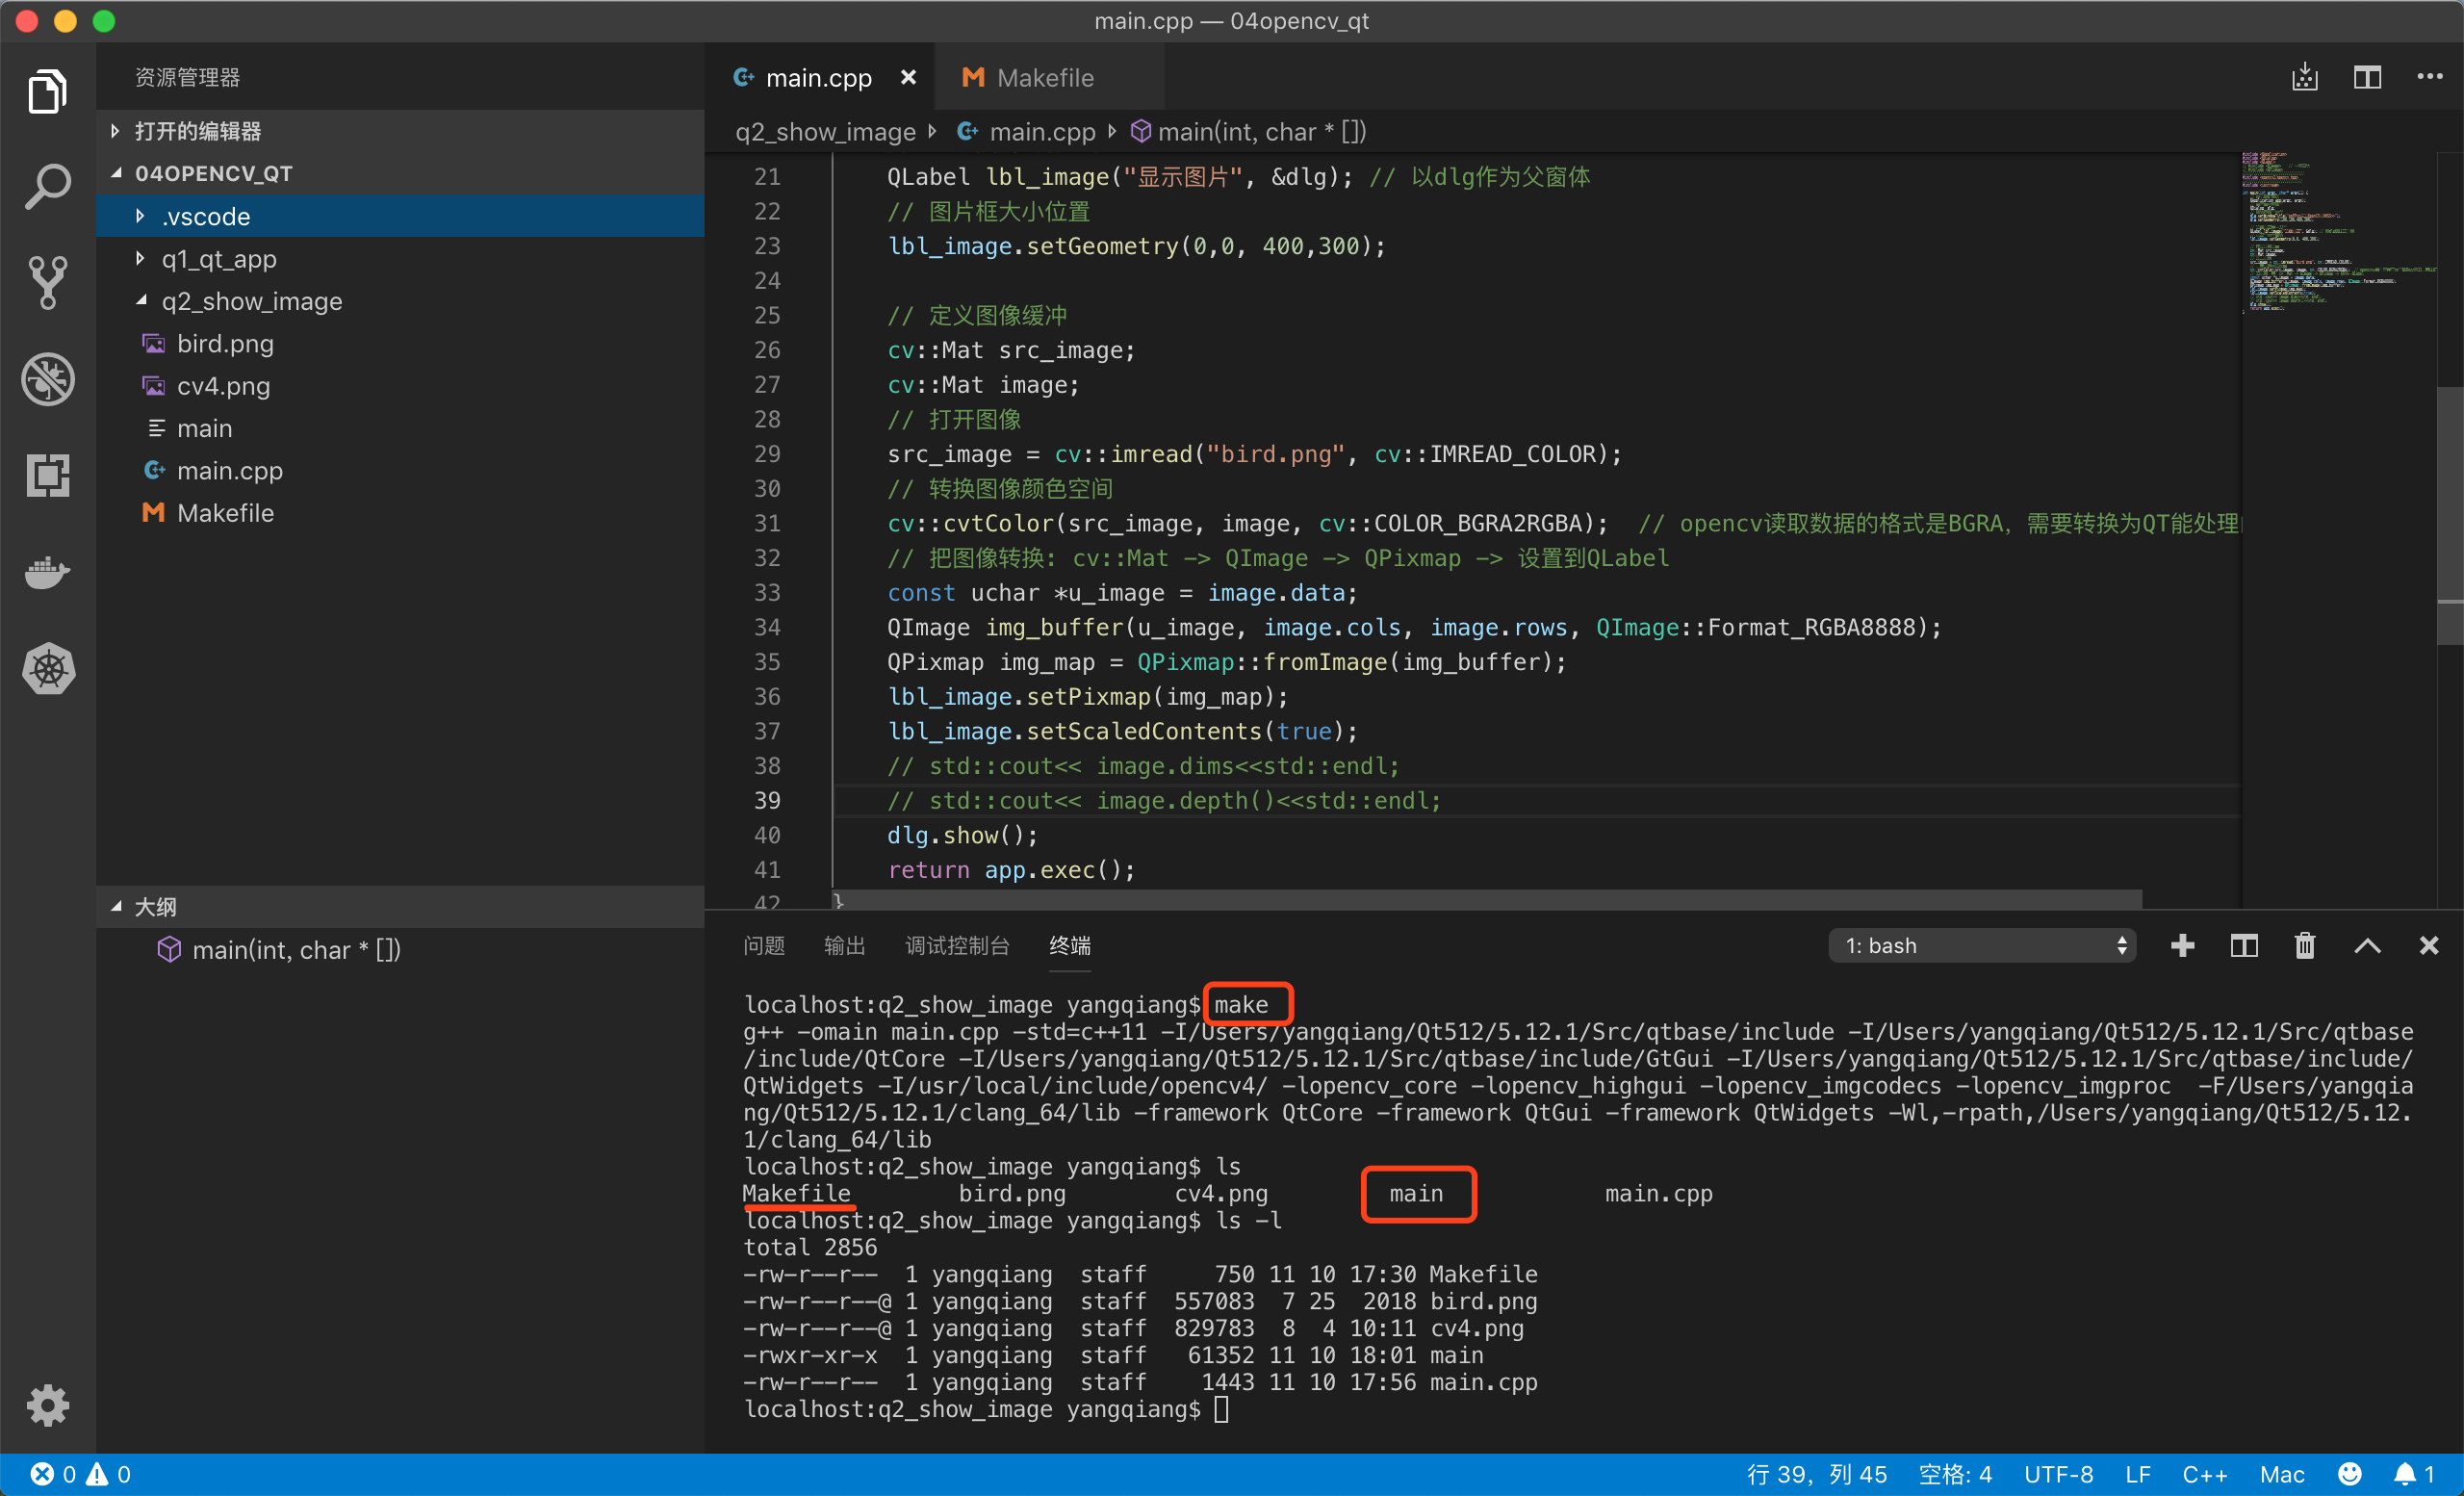

2. 运行结果

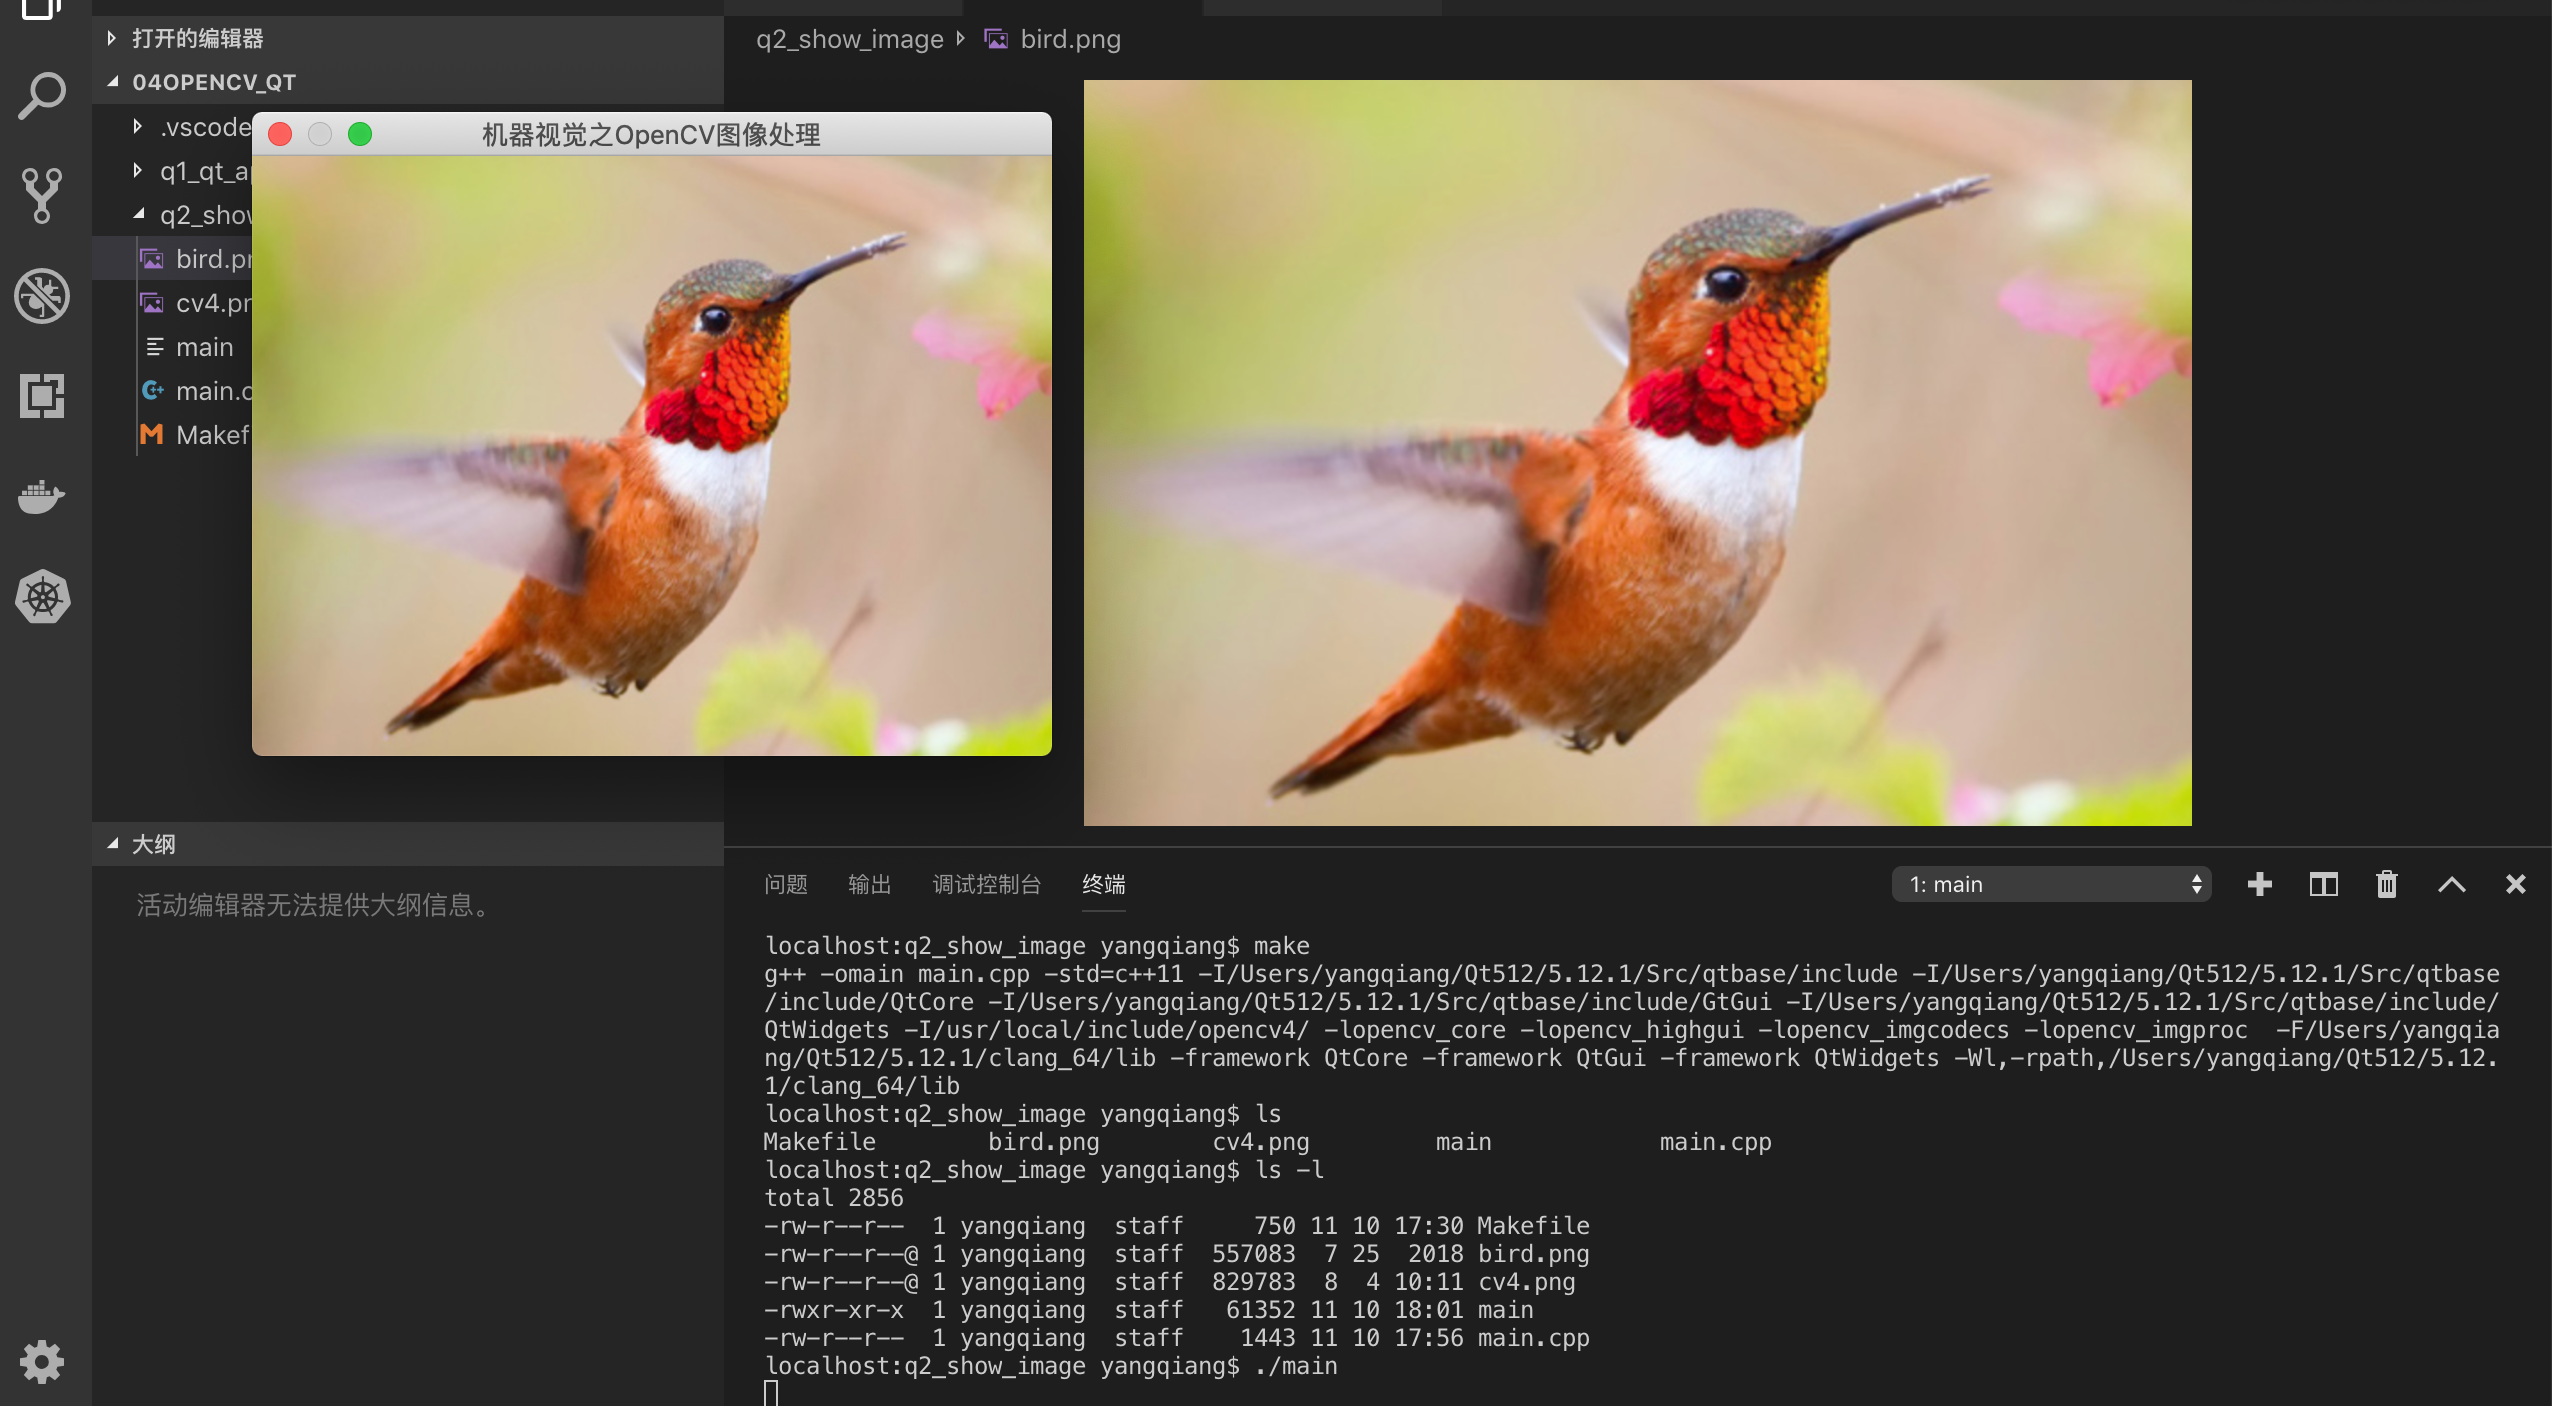

# 附录：

1. OpenCV参考链接
  - `https://docs.opencv.org/4.1.2/`
2. Qt参考链接
  - `https://doc.qt.io/qt-5/`

----